# PC-lab 11: Unsupervised Learning

_Unsupervised learning_ is a different branch of machine learning, as in this case a response variable $y$ is missing. Therefore, unsupervised learning techniques are most often used for exploratory purposes or as a preprocessing step in a supervised context. Unsupervised learning is more prone to subjectivity because results are harder (or even impossible) to validate. This is why one should be careful with the interpretation of results after unsupervised learning. (Those interested can have a look at the paper ["Clustering: Science or Art"](http://proceedings.mlr.press/v27/luxburg12a/luxburg12a.pdf), which summarizes a couple of critics and tries to give some pointers considering the evaluation of clustering algorithms). 

In this PC-lab we will have a look at two frequently applied techniques in the context of unsupervised learning, namely principal component analysis and k-means clustering. We will end with a general scheme, in which both techniques are used. Datasets that will be used in this PC-lab are the `iris`-dataset and `digits`-dataset. 

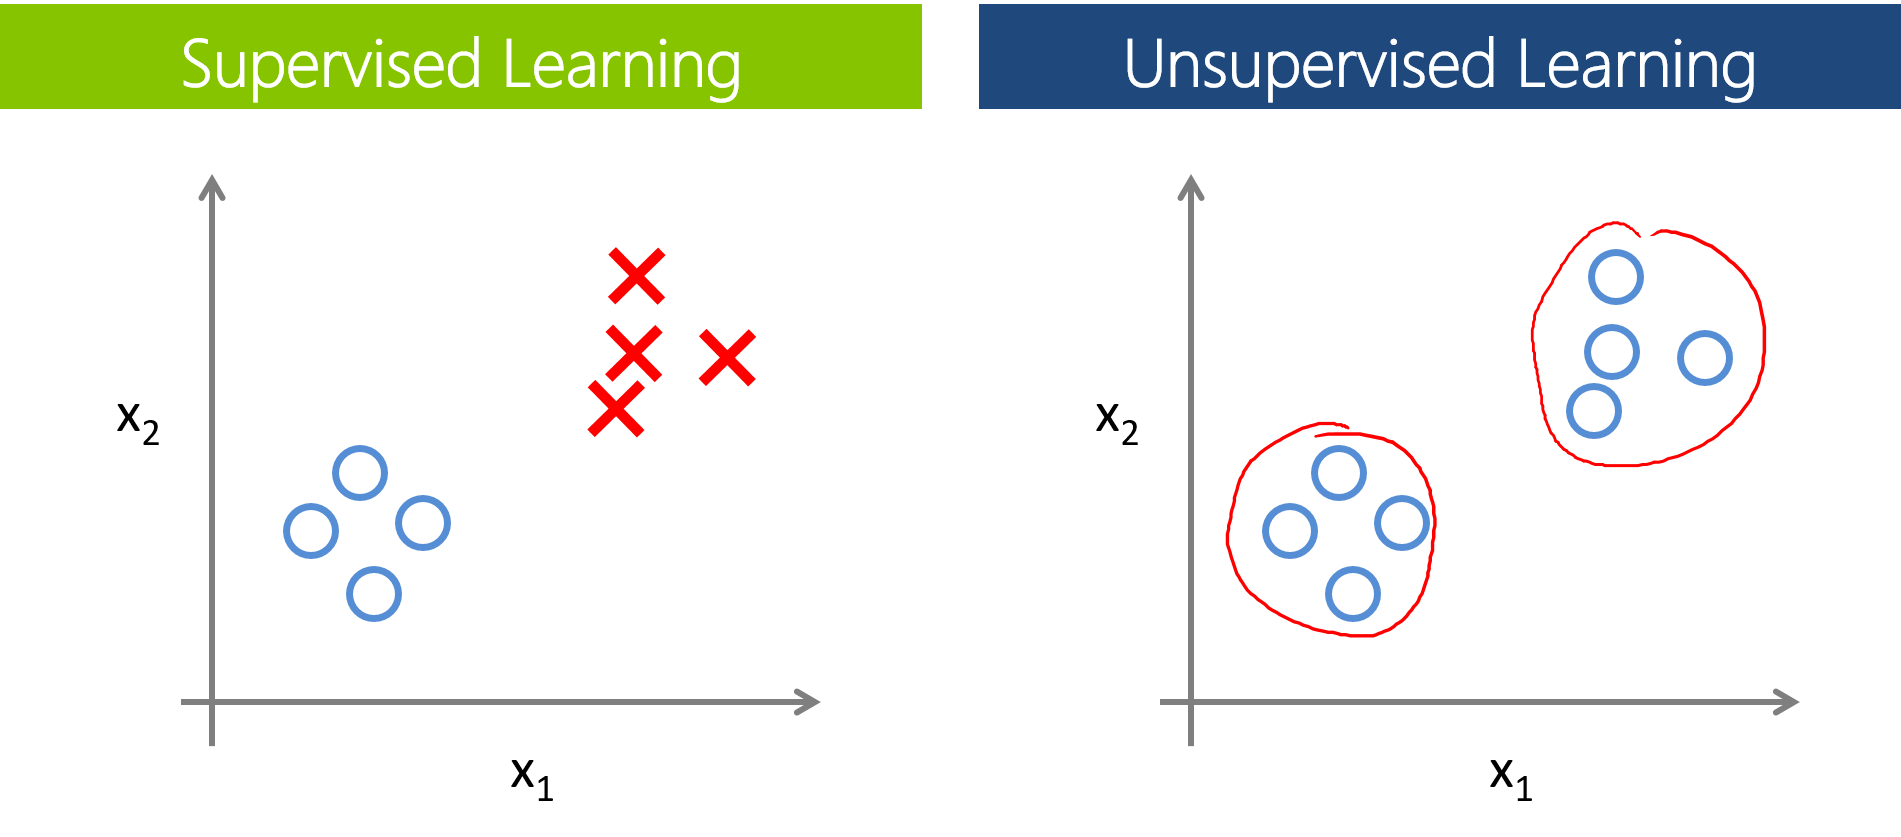

In [1]:
from IPython.display import Image
Image("Supervised_vs_unsupervised.png")

## Dimensionality Reduction: Principal Components Analysis

A popular area of unsupervised learning is the area of _Dimensionality Reduction_, in which one tries to reduce the number of variables for visualization purposes or as a preprocessing step for clustering or classification/regression techniques. An established technique which you will find back in most statistics courses is _Principal Components Analysis_ (PCA). Using this technique, one tries to find a linear combination of $p$ variables for which the first principal component contains the most variance. The second principal component contains a linear combination of all variables that has maximal variance and is _uncorrelated_ with the first principal component. This translates itself to the following optimization scheme, $Z_1$ being the first principal componen, $Z_2$ the second, until the last component $Z_p$: 

\begin{equation}
Z_1 = w_{11}x_{i1} + ... + w_{p1}x_{ip} = \mathbf{w}_1 \cdot \mathbf{x}_i,
\end{equation}

where $w_{11}, ..., w_{p1}$ are the _loadings_ of the first principal component. As PCA determines a _normalized_ linear combination of variables, this means that the equality $\sum_{j=1}^{p} w_{j1}^2 = 1$ has to hold. In other words, the first principal component is determined by: 
\begin{equation}
\text{arg max}_{\mathbf{w}_1} \sum_{i=1}^{n} \mathbf{w}_1 \cdot  \mathbf{x}_i, \quad \text{subject to} \quad ||\mathbf{w}_1|| = 1. 
\end{equation}

The $k$-th component can be determined by subtracting the $k-1$ components from $X = \{\mathbf{x}_1, ..., \mathbf{x}_n\}$: 

\begin{equation}
\hat{X}_k = X - \sum_{s=1}^{k-1} X \mathbf{w}_s \mathbf{w}_s^T, 
\end{equation}

and then finding the loading vector for the $k$-th component: 
\begin{equation}
\text{arg max}_{\mathbf{w}_k}  \mathbf{w}_k\hat{X}_k, \quad \text{subject to} \quad ||\mathbf{w}_k|| = 1. 
\end{equation}

It turns out that this gives the remaining eigenvectors of $X^TX$, of which the eigenvectors are orthogonal to each other. In other words, the principal components are eigenvectors of $X^TX$, for which the eigenvalues will tell you how much variance each component is incorporating. It can be shown that one can decompose $X$ using singular value decomposition as well. 

(Those interested in a non-formal explanation of PCA, check out this intuitive ['dining table-tale'](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) about PCA). 

<div class="alert alert-success">
<b>EXERCISE 1 (warm-up): 
<br>
a) Have a look at the [`iris`](https://en.wikipedia.org/wiki/Iris_flower_data_set) dataset. Reduce the dataset using PCA and visualize its first two components using a scatterplot. Don't forget to preprocess your data. Do you see distinctive groups? 
<br> 
b) How much variance is captured in the first three components? 
</b>
</div>

In [2]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import load_iris, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.utils import resample

import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display, HTML
from IPython.display import Image

plt.style.use('seaborn-white')
%matplotlib inline

In [3]:
iris = load_iris()
X = scale(iris.data)

n_samples, n_features = X.shape
#n_classes = len(np.unique(iris.target))
labels = iris.target

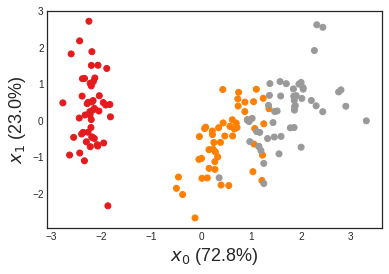

In [4]:
##1a): 
pca = PCA()
pca.fit(X)
X_transformed = pca.transform(X)
var = pca.explained_variance_ratio_

#subset = np.random.choice(np.arange(0,data_transformed.shape[0]), size=300)

fig, ax = plt.subplots()
ax.scatter(X_transformed[:,0],X_transformed[:,1], c=labels, cmap=plt.cm.Set1);
ax.set_xlabel(r'$x_0$ (' + str(np.round(var[0],3)*100) + '%)', size=18)
ax.set_ylabel(r'$x_1$ (' + str(np.round(var[1],3)*100) + '%)', size=18)
plt.show()

In [5]:
##1b): 
expl_var_comp012 = var[0] + var[1] + var[2]
print('Explained variance first three components: ' + str(expl_var_comp012))

Explained variance first three components: 0.994848073191


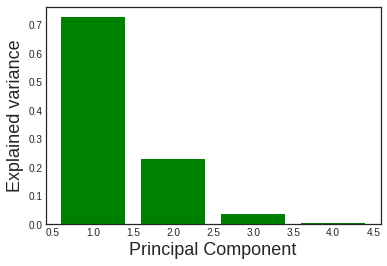

In [6]:
##1b): 
fig, ax = plt.subplots()
ax.bar(np.arange(1,var.shape[0]+1),var,color='g');
ax.set_xlabel('Principal Component', size=18)
ax.set_ylabel('Explained variance', size=18)
plt.show()

## $K$-Means Clustering

$K$-means clustering aims to divide $n$ observations into $k$ clusters of equal variance, minimizing the within-cluster sum-of-squares. Each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. Its objective function can be written as follows, where $S = \{S_1, ..., S_k\}$, the set of $k$ partitions: 

\begin{equation}
\text{arg min}_S \sum_{i=1}^k \sum_{\mathbf{x} \in S_i} ||\mathbf{x} - \boldsymbol{\mu}_i||^2, 
\end{equation}

which is equivalent to minimizing the pairwise squared deviations of points in the same cluster, where $\boldsymbol{\mu}_i$ is the mean of points in partition $S_i$: 

\begin{equation}
\text{arg min}_S \sum_{i=1}^k \frac{1}{2|S_i|} \sum_{\mathbf{x},\mathbf{y} \in S_i} ||\mathbf{x} - \mathbf{y}||^2. 
\end{equation}

$K$-means uses the following three steps, for which step two and three are repeated until convergence is reached: 

1) The first step chooses the initial centroids; most easy way of doing this is by choosing $k$ samples at random from the dataset. 

2) In the second step each element of the dataset is assigned to its nearest centroid. 

3) New centroids are chosen by taking the mean of all clustered samples according to the previous centroid. 

A number of variations exist of the $k$-means algorithm, see for example the [$k$-medoids](https://en.wikipedia.org/wiki/K-medoids) algorithm, which uses datapoints to initialize the algorithm and works with a generalization of the Manhattan Norm to define distance between datapoints. 

Clustering results can be assessed, but need a different kind of metric in order to assess the performance, as typically we don't have labels at our disposal to evaluate our method. One of such metrics is the _Silhouette_-coefficient, which calculates the mean distance for a specific sample $\mathbf{x}_i$ to all the samples in the same cluster ($a$), as opposed to the average distance to all the samples in the nearest cluster ($b$). This gives rise to a silhoutte-coefficient $\text{si}_{\mathbf{x}_i}$: 

\begin{equation}
\text{si}_{\mathbf{x}_i} = \frac{b-a}{\text{max}\{a,b\}}. 
\end{equation}

From this the Silhouette-index for a specific clustering of dataset $X$ can be calculated by just taking the average of all individual silhouette-coefficients: 

\begin{equation}
\text{SI} = \frac{1}{n} \sum_{i=1}^n \text{si}_{\mathbf{x}_i}. 
\end{equation}

<div class="alert alert-success">
<b>EXERCISE 2: 
<br>
Cluster the `iris`-dataset using $k$-means. Determine $k$ using the silhouette-index; let $k$ vary from 2 to 8. Do this for the raw data and on the first two components of the PCA-transformed data. Which $k$ do you find? Visualize one of your clustering results. 
</b>
</div>

In [7]:
##2: 
possible_k = np.arange(2,9)
si = np.zeros(len(possible_k))
i=0
for k in possible_k: 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    si[i] = silhouette_score(X, kmeans.labels_)
    i+=1   

In [8]:
##2: 
si_pca = np.zeros(len(possible_k))
i=0
for k in possible_k: 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_transformed[:,0:2])
    si_pca[i] = silhouette_score(X_transformed[:,0:2], kmeans.labels_)
    i+=1   

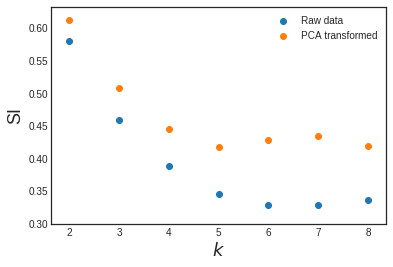

In [9]:
fig, ax = plt.subplots()
ax.scatter(possible_k, si, label='Raw data');
ax.scatter(possible_k, si_pca, label='PCA transformed');
ax.set_xlabel(r'$k$', size=18)
ax.set_ylabel('SI', size=18)
plt.legend()
plt.show()

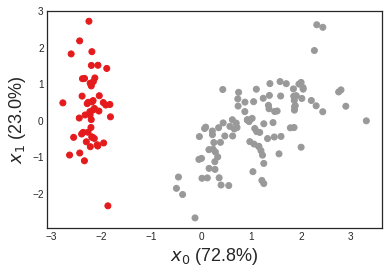

In [10]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_transformed[:,0:2])

fig, ax = plt.subplots()
ax.scatter(X_transformed[:,0],X_transformed[:,1], c=kmeans.labels_, cmap=plt.cm.Set1);
ax.set_xlabel(r'$x_0$ (' + str(np.round(var[0],3)*100) + '%)', size=18)
ax.set_ylabel(r'$x_1$ (' + str(np.round(var[1],3)*100) + '%)', size=18)
plt.show()

## Combining unsupervised techniques

Often you will find that a number of unsupervised techniques are combined when exploratory analyses are conducted. This is typically the case when your number of variables is high, where you might suffer from the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). In these cases, the approaches laid out above can be combined using the following scheme, which can be tweaked in function of your research question:  

1) Compute the principal components using PCA; 

2) Select a reduced number of components in function of the explained variance; 

3) Search for a number of $k$ meaningful clusters; 

4) Cluster your data using these final settings; 

We will use this approach and analyze a more challenging dataset, called the [`digits`-dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html). This dataset consists of handwritten images of the numbers 0-9, which has been proprocessed into feature vectors of length 64. 

<div class="alert alert-success">
<b>EXERCISE 3: 
<br> 
a) Apply the approach illustrated above to the `digits`-dataset. Store and compare the components which explain 50% and 90% of the variance. What's the 'optimal' number of clusters? What do you think of the result? 
<br>
b) (If you have time) Can you find a relation between the number of components you use for clustering (and thus the explained variance) and the 'optimal' number of clusters? How do you evaluate this result? 
</b>
</div>

In [11]:
digits = load_digits()
X = scale(digits.data)
y = digits.target

In [12]:
def return_noc_pca(var, threshold):
    sumvar = 0.
    i = 0
    while sumvar < threshold: 
        sumvar+=var[i]
        i+=1
    return i    

In [13]:
##3a): 
pca.fit(X)
X_transformed = pca.transform(X)
var = pca.explained_variance_ratio_

In [14]:
##3a):
noc_50 = return_noc_pca(var,0.5)
noc_90 =return_noc_pca(var,0.9)
possible_k = np.arange(2,41,2)
si_pca_50 = np.zeros(len(possible_k))
si_pca_90 = np.zeros(len(possible_k))
j=0

for k in possible_k: 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_transformed[:,0:noc_50])
    si_pca_50[j] = silhouette_score(X_transformed[:,0:noc_50], kmeans.labels_)
    kmeans.fit(X_transformed[:,0:noc_90])
    si_pca_90[j] = silhouette_score(X_transformed[:,0:noc_90], kmeans.labels_)
    j+=1

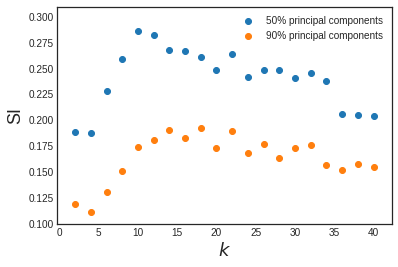

In [15]:
fig, ax = plt.subplots()
ax.scatter(possible_k, si_pca_50, label='50% principal components');
ax.scatter(possible_k, si_pca_90, label='90% principal components');
ax.set_xlabel(r'$k$', size=18)
ax.set_ylabel('SI', size=18)
plt.legend()
plt.show()

No handles with labels found to put in legend.


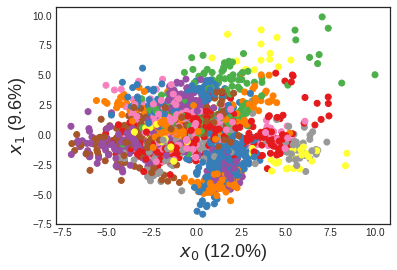

In [16]:
kmeans.fit(X_transformed[:,0:noc_50])

fig, ax = plt.subplots()
ax.scatter(X_transformed[:,0],X_transformed[:,1], c=kmeans.labels_, cmap=plt.cm.Set1);
ax.set_xlabel(r'$x_0$ (' + str(np.round(var[0],3)*100) + '%)', size=18)
ax.set_ylabel(r'$x_1$ (' + str(np.round(var[1],3)*100) + '%)', size=18)
plt.legend()
plt.show()

No handles with labels found to put in legend.


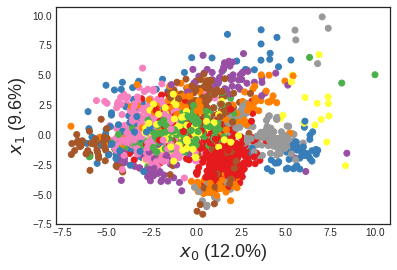

In [17]:
kmeans.fit(X_transformed[:,0:noc_90])

fig, ax = plt.subplots()
ax.scatter(X_transformed[:,0],X_transformed[:,1], c=kmeans.labels_, cmap=plt.cm.Set1);
ax.set_xlabel(r'$x_0$ (' + str(np.round(var[0],3)*100) + '%)', size=18)
ax.set_ylabel(r'$x_1$ (' + str(np.round(var[1],3)*100) + '%)', size=18)
plt.legend()
plt.show()

In [18]:
##3b):

var_dummy = 0
poss_var = [0.2,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.98,0.99]
k_var = np.zeros(len(poss_var))
max_var = np.zeros(len(poss_var))
expl_var = np.zeros(len(poss_var))
possible_k = np.arange(2,41,2)

i=0
for v in poss_var: 
    noc = return_noc_pca(var, v)
    j=0
    si_pca = np.zeros(len(possible_k))    
    for k in possible_k: 
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_transformed[:,0:noc])
        si_pca[j] = silhouette_score(X_transformed[:,0:noc], kmeans.labels_)
        j+=1
    max_var[i] = si_pca.max()
    k_var[i] = possible_k[si_pca.argmax()]
    i+=1 

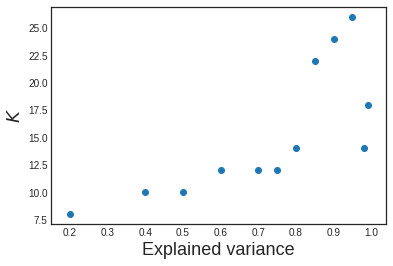

In [19]:
fig, ax = plt.subplots()
ax.scatter(poss_var, k_var);
ax.set_xlabel('Explained variance', size=18)
ax.set_ylabel(r'$K$', size=18)
plt.show()